## Бутстрап
Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках экспериментва

В полученных подвыборках считаются статистики (среднее, медиана и т.п.)

Из статистик можно получить ее распределение и взять доверительный интервал

ЦПТ, например, не позволяет строить доверительные интервал для медианы, а бутстрэп это может сделать

In [1]:

import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import seaborn as sns

plt.style.use('ggplot')

C:\Users\vitaly.flerin\Miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

# На нашем курсе по аналитике https://karpov.courses/ секцию про bootstrap читают ребята из https://www.experiment-fest.ru/
# Функция get_bootstrap взята из их занятия по АБ тестам

In [6]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [ ]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

In [7]:
n = 1000

sample_1 = np.random.exponential(scale=1/0.001, size=n)
sample_2 = np.random.exponential(scale=1/0.00101, size=n)

df = pd.DataFrame({
    "sample_1": sample_1,
    "sample_2": sample_2
})

In [9]:
booted_data = get_bootstrap(df.sample_1, df.sample_2) # в результате хранится разница двух распределений, ДИ и pvalue

NameError: name 'tqdm' is not defined

In [ ]:
booted_data["p_value"] # альфа

0.07704553867678232

In [ ]:
booted_data["quants"] # ДИ

,0
0.025,-161.943418
0.975,5.328283


In [14]:
data_ab=pd.read_csv(r"C:\Users\vitaly.flerin\Desktop\qwe.csv", sep=';')

In [12]:
data_ab.head()

NameError: name 'data_ab' is not defined

In [15]:
data_ab.dtypes

flag    object
nps      int64
dtype: object

In [16]:
data_ab.groupby('flag').agg({'nps': 'count'})

,nps
flag,
lsub,2067
sub,1629


In [17]:
data_ab.groupby('flag').agg({'nps': 'mean'})

,nps
flag,
lsub,0.256410
sub,0.163904


In [18]:
data_ab.groupby('flag').agg({'nps': 'median'})

,nps
flag,
lsub,1.0
sub,0.0


c:\Users\vitaly.flerin\Miniconda3\envs\python3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='nps'>

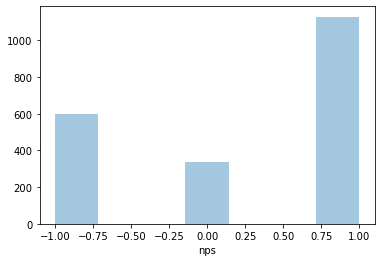

In [19]:
sns.distplot(data_ab[data_ab.flag == 'lsub'].nps, kde=False)

<AxesSubplot:xlabel='nps'>

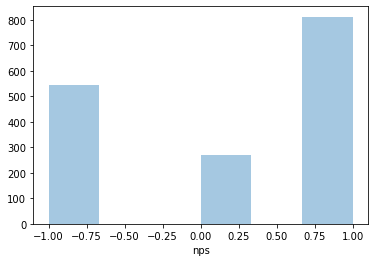

In [20]:
sns.distplot(data_ab[data_ab.flag == 'sub'].nps, kde=False)

In [22]:
mannwhitneyu(data_ab[data_ab.flag == 'sub'].nps, 
             data_ab[data_ab.flag == 'isub'].nps)

ValueError: `x` and `y` must be of nonzero size.

In [23]:
ttest_ind(data_ab[data_ab.flag == 'lsub'].nps, 
             data_ab[data_ab.flag == 'sub'].nps)

Ttest_indResult(statistic=3.1472795687546866, pvalue=0.0016610954703394135)

In [26]:
get_bootstrap(
    data_ab[data_ab.flag == 'lsub'].nps, # числовые значения первой выборки
    data_ab[data_ab.flag == 'sub'].nps, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

NameError: name 'tqdm' is not defined

In [25]:
get_bootstrap(
    data_ab[data_ab.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    data_ab[data_ab.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

AttributeError: 'DataFrame' object has no attribute 'experimentVariant'

In [ ]:
5.4687657931866705e-08 < 0.0000002

True

In [ ]:
ads_data = pd.read_csv('ads_data.csv.zip')

In [ ]:
ads_data.groupby(['ad_id', 'event'], as_index=False) \
    .agg({'time': 'count'}) \
    .pivot(index='ad_id', columns='event', values='time') \
    .reset_index()

event,ad_id,click,view
0,3,9.0,490.0
1,2132,1.0,95.0
2,2276,2.0,1454.0
3,2475,NaN,132.0
4,2643,3.0,286.0
...,...,...,...
350,121941,1.0,640.0
351,121943,15.0,1722.0
352,122042,1.0,155.0
353,122063,1.0,260.0
